In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Activation

import tensorboard

In [29]:
directory = 'datathon 2022 dataset'
# ims = 256
image_size = (222,294)
# Generates a tf.data.Dataset from image files in a directory.
df = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size = image_size,
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    crop_to_aspect_ratio=False,
)

Found 2985 files belonging to 5 classes.


In [30]:
class_names = df.class_names
print(class_names)

['Acne', 'Cyst, tumour and skin-tags', 'Melanoma', 'Moneypox', 'Normal skin']


In [31]:
# plt.figure(figsize=(10, 10))
# for images, labels in df.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


In [32]:
# print(len(df))

In [33]:
# tf.take(10) will take 10 image sets from the dataset
# tf.skip(10) will skip 10 image sets from the dataset
# doen't need to shuffle the dataset as it is already shuffled

train_ds = df.take(64)
test_ds = df.skip(64)

val_ds = test_ds.take(20)
test_ds = test_ds.skip(20)

In [34]:
# print(len(df), len(train_ds), len(val_ds), len(test_ds))

In [35]:
# cache the dataset in the memory to improve performance
# prefetch the dataset to improve performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
data_augmentation = Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
])

In [37]:
# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [38]:
# remving the classification layer by include_top=False
IMG_SHAPE = image_size + (3,)
base_model = keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')  # weights='imagenet' loads the weights pre-trained on ImageNet.

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 470

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


In [40]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(254, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax'),
])
model.build(input_shape=(None, image_size[0], image_size[1], 3))

In [41]:
# model.summary()

In [42]:
model.compile(optimizer=keras.optimizers.RMSprop(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])


In [43]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
64/64 [==============================] - 94s 1s/step - loss: 0.6368 - accuracy: 0.7769 - val_loss: 0.3105 - val_accuracy: 0.8766
Epoch 2/10
64/64 [==============================] - 57s 890ms/step - loss: 0.4166 - accuracy: 0.8564 - val_loss: 0.3215 - val_accuracy: 0.8984
Epoch 3/10
64/64 [==============================] - 56s 872ms/step - loss: 0.3356 - accuracy: 0.8838 - val_loss: 0.2799 - val_accuracy: 0.9187
Epoch 4/10
64/64 [==============================] - 59s 926ms/step - loss: 0.2765 - accuracy: 0.9019 - val_loss: 0.3434 - val_accuracy: 0.8984
Epoch 5/10
64/64 [==============================] - 58s 906ms/step - loss: 0.2465 - accuracy: 0.9233 - val_loss: 0.4481 - val_accuracy: 0.9031
Epoch 6/10
64/64 [==============================] - 58s 914ms/step - loss: 0.2214 - accuracy: 0.9292 - val_loss: 0.3786 - val_accuracy: 0.9094


In [44]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

10/10 [==============================] - 9s 193ms/step - loss: 0.4217 - accuracy: 0.9226
Test accuracy : 0.9225589036941528


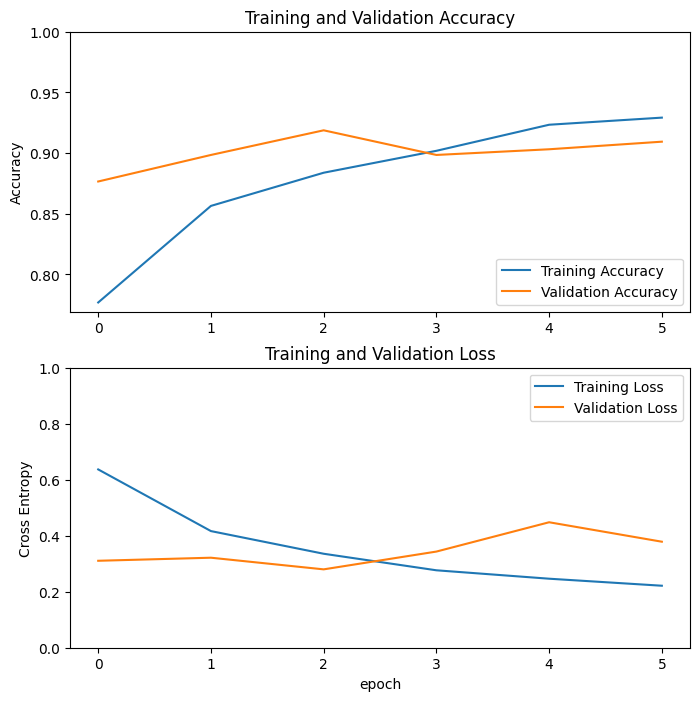

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
class_names = df.class_names
 

def predict(model, img):

    # Returns a tensor with a length 1 axis inserted at index axis.
    # (256, 256, 3) to (1, 256, 256, 3)
    img_array = tf.expand_dims(img,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 71ms/step


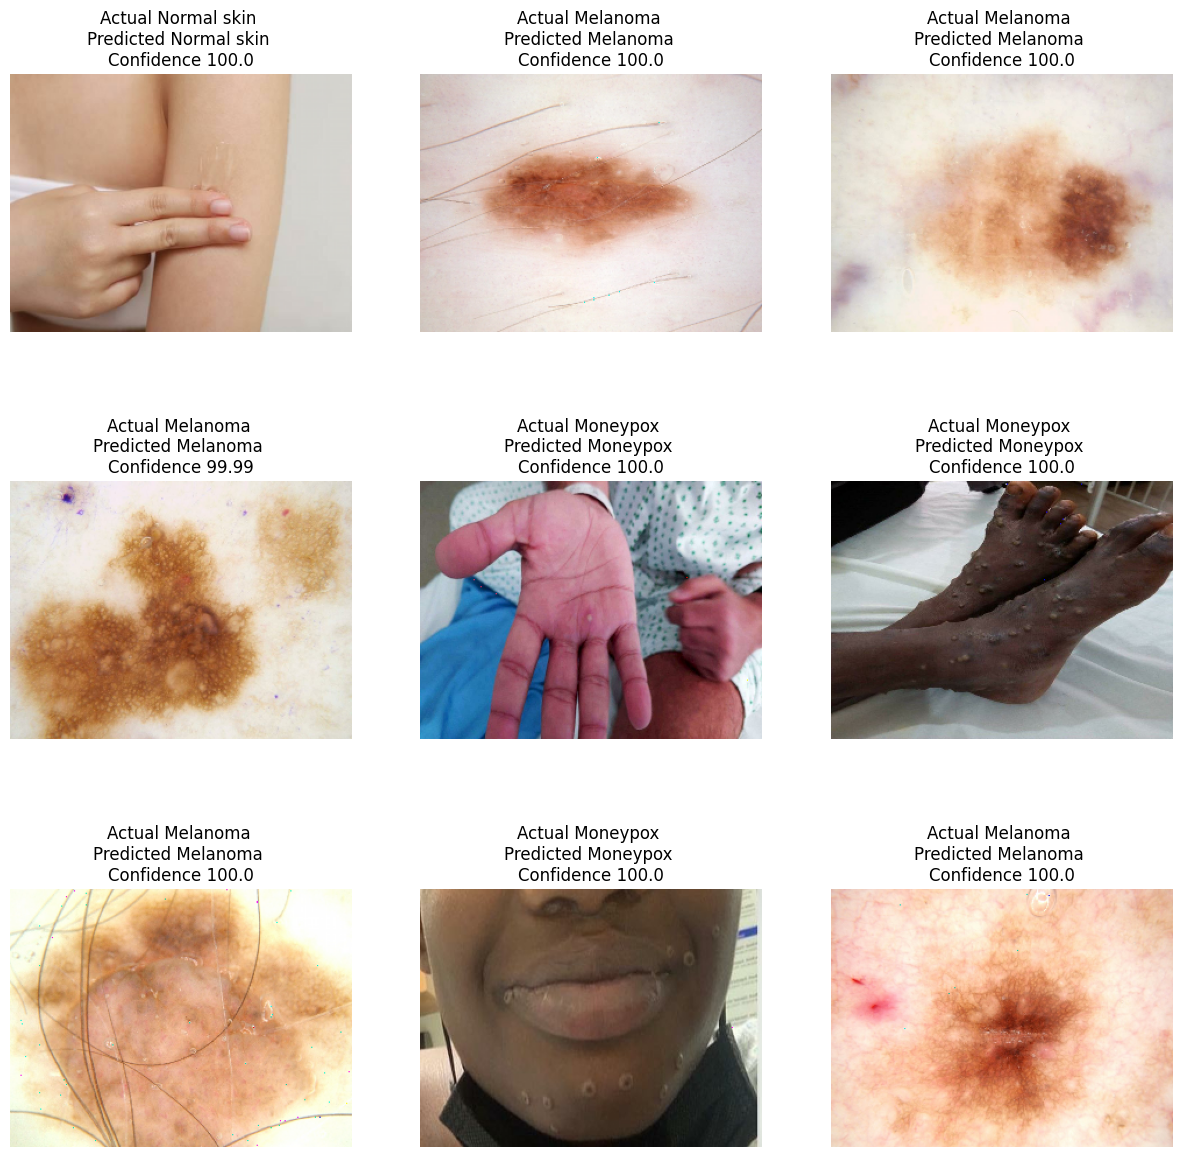

In [47]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual {actual_class} \nPredicted {predicted_class} \nConfidence {confidence}')
        plt.axis('off')